In [1]:
import yaml
import os

import imageio
import numpy as np
import pandas as pd
import xarray as xr
import polars as pl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 

from Toy_ML import MLModel, poly_fit, compare_model_obs
from data_plotting import ArcticPlotter, OxygenIsotopePlots
from netcdf_climate_analysis_funcs import climdata, multiplot, climatology, add_region_highlight
from netcdf_climate_analysis_funcs.small_funcs import timeseg, xy_region
from glomar_gridding.grid import map_to_grid, grid_from_resolution

with open("config.yaml", "r") as f:
    CONFIG = yaml.safe_load(f)
# check cuda is availble
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/users/thopri/.conda/envs/AISIT/lib/python3.13/site-packages/symfit/core/printing.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/users/thopri/.conda/envs/AISIT/lib/python3.13/site-packages/netcdf_climate_analysis_funcs/small_funcs/regridding.py:17: UserWarning: xESMF package is not installed by default. If you want to use the regridding features, please install the xESMF package separately. Refer to the README document for more information on how to do this.
  warnings.warn(


cuda


# Case Study: Applying Machine Learning to generate Arctic Oxygen Isotope Tracer datasets

We present a simple machine learning model that can be used to produce a spatially-complete, Arctic-focussed oxygen isotope tracer dataset from in-situ data, provided by BAS as part of the BIOPOLE project 

## 1. The Data

### 1.1. Load the data

#### 1.1.1. BAS Pre-alpha

In [2]:
# Name of columns
latitude_field = "Latitude_[degN]"
longitude_field = "Longitude_[degE]"
temperature_field = "Temperature_[degC]"
salinity_field = "CTD_Salinity_[standard_salinity_units]"
depth_field = "combined_depth_[meters_below_surface]"
# pressure_field = "CTD_Pressure_[dbar]"
oxygen_iso_field = "DELO18_[permillle]"
reference_field = "Dataset"
dt_format = "Sample_Date_[dd/mm/yyyy]"

In [3]:
# --- Load CSV ---
df_inp = pd.read_csv(CONFIG["BAS_prealpha"])

# --- QC data ---
# Replace missing or placeholder values (like '**') with NaN
df = df_inp.replace(["-", "**"], np.nan)

# Convert columns to numeric
df[longitude_field] = pd.to_numeric(df[longitude_field])
df[latitude_field] = pd.to_numeric(df[latitude_field])
df[salinity_field] = pd.to_numeric(df[salinity_field])
df[temperature_field] = pd.to_numeric(df[temperature_field])
df[depth_field] = pd.to_numeric(df[depth_field])
# df[pressure_field] = pd.to_numeric(df[pressure_field])
df[oxygen_iso_field] = pd.to_numeric(df[oxygen_iso_field])

df["datetime"] = pd.to_datetime(df[dt_format], format="mixed")
df = df.drop(columns=dt_format)

# Convert outlandish values to NaN
# df[longitude_field] = df.where(df[longitude_field] <= 180, np.nan)[longitude_field]
# df[salinity_field] = df.where(df[salinity_field] > 10, np.nan)[salinity_field]
# df[oxygen_iso_field] = df.where((df[oxygen_iso_field] > -10) & (df[oxygen_iso_field] < 10), np.nan)[oxygen_iso_field]
# df[temperature_field] = df.where((df[temperature_field] > -5) & (df[temperature_field] < 50), np.nan)[temperature_field]
# df[pressure_field] = df.where(df[pressure_field] < 180, np.nan)[pressure_field]
# df[depth_field] = df.where(df[depth_field] >-1, np.nan)[depth_field]

# Cartesian coordinates
R = 6371e3  # Earth radius in meters
df["x"] = R * np.cos(np.deg2rad(df[latitude_field])) * np.cos(np.deg2rad(df[longitude_field]))
df["y"] = R * np.cos(np.deg2rad(df[latitude_field])) * np.sin(np.deg2rad(df[longitude_field]))


/tmp/ipykernel_2097/3348552509.py:2: DtypeWarning: Columns (0: DELO18_WOCE_FLAG_Original, 1: Site_Number_Name, 2: Sample_ID, 3: Event, 4: Platform, 5: Freshwater_Source) have mixed types. Specify dtype option on import or set low_memory=False.
  df_inp = pd.read_csv(CONFIG["BAS_prealpha"])


In [4]:
# Count the number of observations in each month of a year
df["datetime"].dt.month.value_counts().sort_index()

datetime
1     11661
2      1650
3      1920
4      2168
5      2787
6      2407
7      8632
8      7130
9      6452
10     3078
11     2197
12     1971
Name: count, dtype: int64

In [5]:
# Count the number of observations in each year of the dataset
df["datetime"].dt.year.value_counts().sort_index()

datetime
1961      49
1962      80
1963      90
1964      89
1965      87
        ... 
2021    1130
2022    1251
2023     554
2024     757
2025      27
Name: count, Length: 65, dtype: int64

Now, we QC for different input variables. We definitely want longitude & latitude as an input, but other options are:
* Salinity only
* Temperature only
* Pressure only
* Salinity & temperature
* Salinity & pressure

Note that "pressure" and "depth" are synonymous

In [6]:
# First, we need to QC the data depending on which variables we are using
var_dic = {"S": [salinity_field, longitude_field, latitude_field],
           "T": [temperature_field, longitude_field, latitude_field],
           "P": [depth_field, longitude_field, latitude_field],
           "ST": [salinity_field, temperature_field, longitude_field, latitude_field],
           "TP": [temperature_field, depth_field, longitude_field, latitude_field],
           "SP": [salinity_field, depth_field, longitude_field, latitude_field],
           "STP": [salinity_field, temperature_field, depth_field, longitude_field, latitude_field]
}

df_qc_dic = {"S": df.dropna(subset=[*var_dic["S"], oxygen_iso_field]),
             "T": df.dropna(subset=[*var_dic["T"], oxygen_iso_field]),
             "P": df.dropna(subset=[*var_dic["P"], oxygen_iso_field]),
              "ST": df.dropna(subset=[*var_dic["ST"], oxygen_iso_field]),
              "TP": df.dropna(subset=[*var_dic["TP"], oxygen_iso_field]),
              "SP": df.dropna(subset=[*var_dic["SP"], oxygen_iso_field]),
              "STP": df.dropna(subset=[*var_dic["STP"], oxygen_iso_field])
}

In [7]:
print(f"Pre-QC, there are {len(df)} data points.")
for key, val in df_qc_dic.items():
    print(f"The percentage of data lost for {key} QC is {np.round((len(df) - len(val))/len(df)*100, 2)}%")

Pre-QC, there are 52053 data points.
The percentage of data lost for S QC is 26.71%
The percentage of data lost for T QC is 28.88%
The percentage of data lost for P QC is 23.4%
The percentage of data lost for ST QC is 30.44%
The percentage of data lost for TP QC is 31.81%
The percentage of data lost for SP QC is 29.29%
The percentage of data lost for STP QC is 32.88%


#### 1.1.2. Arctic Ocean Reanalysis

Taken from the Copernicus Data Service

In [21]:
# Load in model data
aor = climdata(CONFIG["arctic_reanalysis"])

sal_aor = aor.so
temp_aor = aor.thetao

FileNotFoundError: No such file or directory: /noc/mpoc/surface/acable/arctic_ocean_reanalysis/aor_ts.nc

### 1.2. What does the data look like? 

#### 1.2.1. Spatial plots

First let us consider the spatial sampling of the data. 

We see that there is quite a spread across the Arctic region.
* In the 1980s, most of the data is confined to the ~0E
* In the late 2010s, the data is around the pole
* Between these dates, the data is more spread

In [12]:
# Call class
df_qcd = df_qc_dic["STP"]
arcticplot = ArcticPlotter(df_qcd[latitude_field], df_qcd[longitude_field])

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from BAS Prealpha database'}>)

/home/users/thopri/.conda/envs/AISIT/lib/python3.13/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


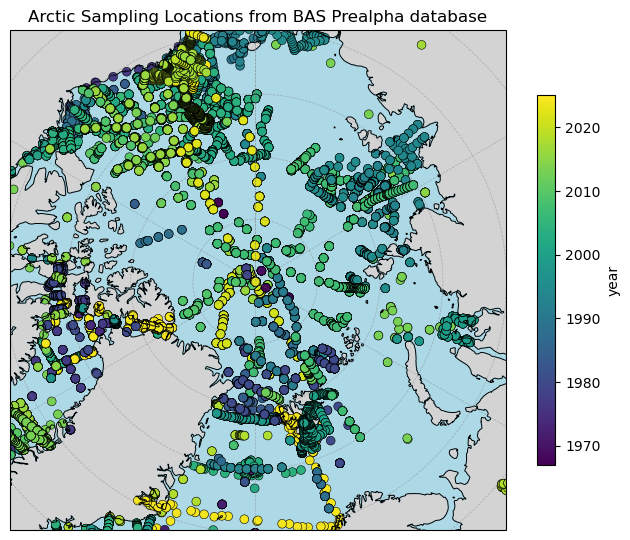

In [13]:
# Plot by year
arcticplot.title = "Arctic Sampling Locations from BAS Prealpha database"
arcticplot.plot(cbar_data=df_qcd["datetime"].dt.year)

A fundamental problem with this dataset is that there isn't enough data to be able to train the model on a regional basis, which we suggest will have a substantial influence on the oxygen isotopes. Unfortunately, there isn't a clear pattern in salinity, temperature or depth that would point to specific locations, as seen below

(<Figure size 800x800 with 2 Axes>,
 <GeoAxes: title={'center': 'Arctic Sampling Locations from BAS Prealpha database'}>)

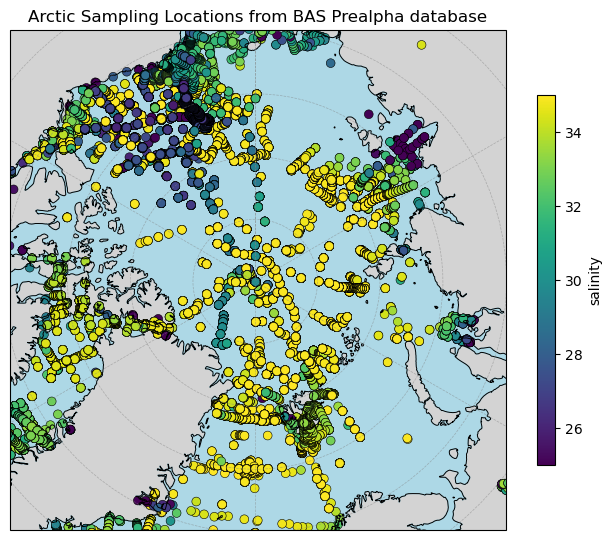

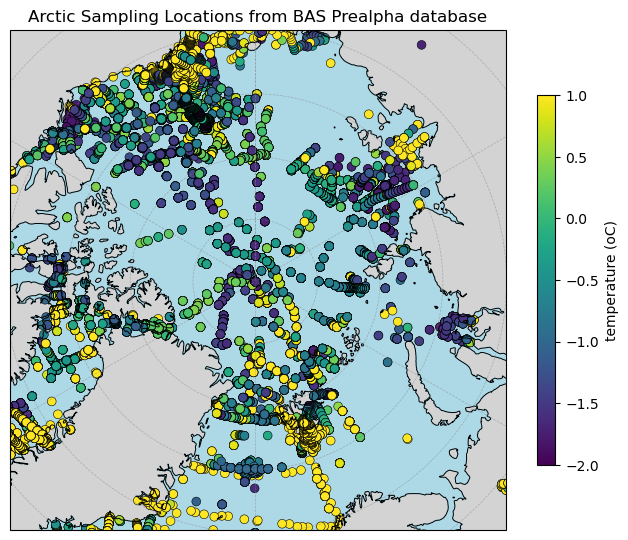

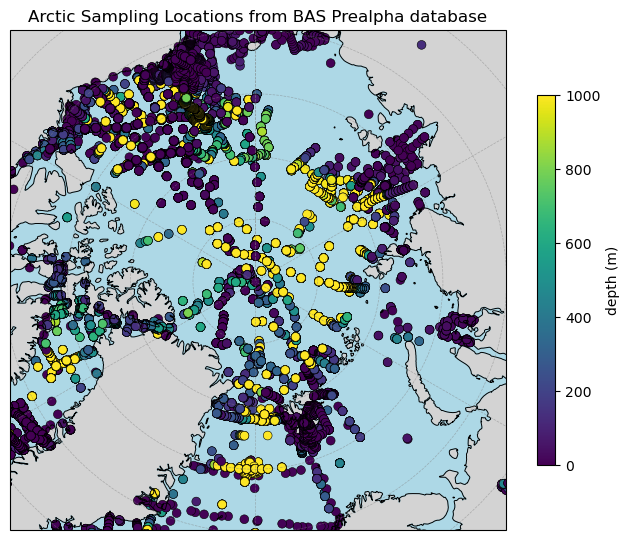

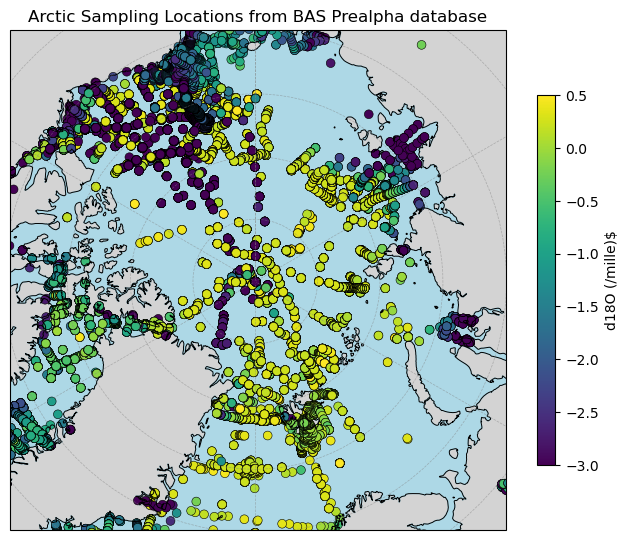

In [14]:
# Plot salinity over space
arcticplot.cbar_title = "salinity"
arcticplot.plot(cbar_data=df_qcd[salinity_field], vmin=25, vmax=35)

# Plot temperature over space
arcticplot.cbar_title = "temperature (oC)"
arcticplot.plot(cbar_data=df_qcd[temperature_field], vmin=-2, vmax=1)

# Plot depth over space
arcticplot.cbar_title = "depth (m)"
arcticplot.plot(cbar_data=df_qcd[depth_field], vmin=0, vmax=1000)

# Plot oxygen isotope over space
arcticplot.cbar_title = f"d18O (/mille)$"
arcticplot.plot(cbar_data=df_qcd[oxygen_iso_field], vmin=-3, vmax=0.5)


#### 1.2.2. δ¹⁸O plots

Now, let's consider the relationship between δ¹⁸O and temperature, salinity & depth. 

We can see that the strongest trend is in the salinity data. Temperature and depth are largely constant with δ¹⁸O except close to the origin (-2oC & 0m).

In [15]:
# Call class
d18o_plot = OxygenIsotopePlots(x=salinity_field, y=oxygen_iso_field, ref=reference_field)

# --- Scatter plot: d18O vs. Salinity ---
fig = d18o_plot.plot(df)
fig.show()

# --- Scatter plot: d18O vs. Salinity ---
d18o_plot.x = temperature_field
d18o_plot.title = "δ¹⁸O vs. Temperature from BAS Prealpha database"
d18o_plot.x_title = "temperature (oC)"

fig = d18o_plot.plot(df)
fig.show()

# --- Scatter plot: d18O vs. Depth ---
d18o_plot.x = depth_field
d18o_plot.title = "δ¹⁸O vs. Depth from BAS Prealpha database"
d18o_plot.x_title = "depth (m)"

fig = d18o_plot.plot(df)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

#### 1.2.3. AOR Plots

Now, we want to have a look at the AOR data and how it compares to the in-situ

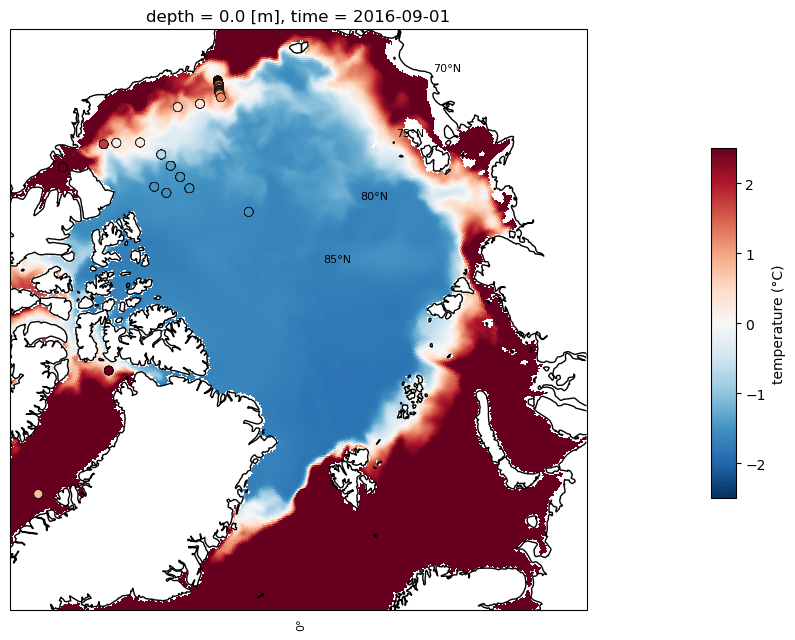

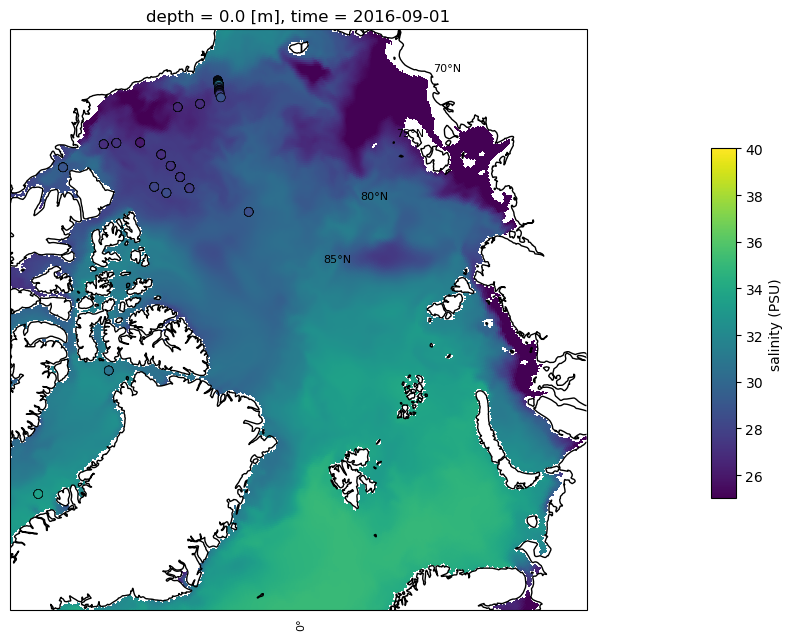

In [24]:
# Select a month to compare the data with the model (same as in Sec. 1.2.3)
mo, yr = 9, 2016
df_1month = df_qcd[(df_qcd["datetime"].dt.year == yr) & (df_qcd["datetime"].dt.month == mo)]
arcticplot.lon, arcticplot.lat = df_1month[longitude_field], df_1month[latitude_field] 

# Plot temperature
fig, ax, p = multiplot(temp_aor.sel(time=f"{yr}-{mo}-01"), vmin=-2.5, vmax=2.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)), cbar_label="temperature (°C)")

sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[temperature_field], vmin=-2.5, vmax=2.5, cmap="RdBu_r")

# Plot salinity
fig, ax, p = multiplot(sal_aor.sel(time=f"{yr}-{mo}-01"), vmin=25, vmax=40, cmap="viridis", map_type="NorthPolarStereo", xyreg=(False,(70,90)), cbar_label="salinity (PSU)")

sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[salinity_field], vmin=25, vmax=40)

In [22]:
## Compare the AOR temp & salinity with BAS Prealpha observations
rmse_temp = compare_model_obs(df_qcd, temp_aor, temperature_field, [], "datetime", longitude_field, latitude_field)
rmse_salinity = compare_model_obs(df_qcd, sal_aor, salinity_field, [], "datetime", longitude_field, latitude_field)

print(f"RMSE for temperature: {rmse_temp:.3f} °C")
print(f"RMSE for salinity: {rmse_salinity:.3f} PSU")

RMSE for temperature: 2.361 °C
RMSE for salinity: 3.613 PSU


## 2. Modelling the data

We start by training, inferring and applying the model to the BAS dataset with no adaptations beyond the above QC.

### 2.1. Train the model on all the data

First thing to do is train the model on all the data. For the BAS pre-alpha, we have various options with which to train the data. We can select from the above QC dictionary

In [8]:
df_qcd = df_qc_dic["STP"]

In [9]:
# Create the 90% for training & 10% for inference
df_10 = df_qcd.sample(frac=0.10)  # 10% sample
df_90 = df_qcd.drop(df_10.index)  # get rest

(array([1028.,   78.,  120.,  118.,  117.,  624.,  547.,  488.,  195.,
         179.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <BarContainer object of 10 artists>)

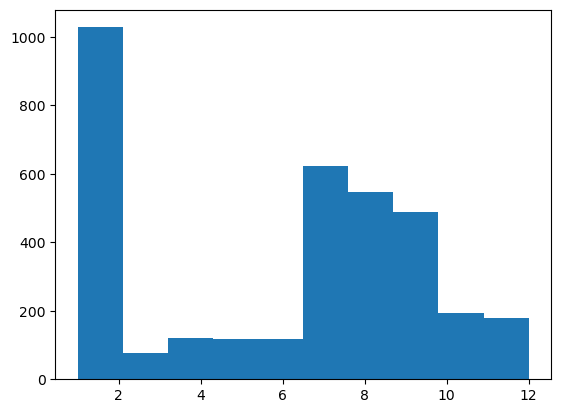

In [10]:
# Add a plot of distribution across the months for 10% as a check
plt.hist(df_10['datetime'].dt.month)

In [15]:
# Call the ML model
ml_model = MLModel(df_90, df_10, [salinity_field, temperature_field, depth_field, "x", "y"], oxygen_iso_field)
# Training
trained_model = ml_model.training(device=device)
# Inference
model_test = ml_model.inference(trained_model[1], trained_model[0])

ML Predicted Oxygen RMSE: 0.5894244110222499
ML Predicted Oxygen R2: 0.8357119023572648
ML Predicted Oxygen Error Percentiles [0.00818271 0.04327558 0.11738595 0.28207866 0.88227658]


#### 2.2.1. Compare the model with a polynomial fit

In [16]:
poly_test = poly_fit(df_90, 
         df_10, 
         salinity_field,
         oxygen_iso_field,
         create_plot=False
         )

Poly Predicted Oxygen RMSE: 0.8104857184871945
Poly Predicted Oxygen R2: 0.6320117191220314
Poly Predicted Oxygen Error Percentiles [0.04653908 0.22620548 0.34832387 0.62179791 1.6292088 ]


In [17]:
print("Different fits to models")
print(f"RMSE: ML {model_test[1]} v polynomial {poly_test[1]}")
print(f"R2: full {model_test[2]} v polynomial {poly_test[2]}")
print(f"Error Percentiles: full {np.percentile(model_test[3], [5, 25, 50, 75, 95])} v polynomial {np.percentile(poly_test[3], [5, 25, 50, 75, 95])}")

Different fits to models
RMSE: ML 0.5894244110222499 v polynomial 0.8104857184871945
R2: full 0.8357119023572648 v polynomial 0.6320117191220314
Error Percentiles: full [0.00818271 0.04327558 0.11738595 0.28207866 0.88227658] v polynomial [0.04653908 0.22620548 0.34832387 0.62179791 1.6292088 ]


#### 2.2.2. Comparing the training with different input variables

NOTE: This takes a while to run as it trains multiple times

In [18]:
# Then we create the 90% and 10%
df_10_dic = {key: df_qc_dic[key].sample(frac=0.10) for key in df_qc_dic.keys()}
df_90_dic = {key: df_qc_dic[key].drop(df_10_dic[key].index) for key in df_qc_dic.keys()}

# Train the model for the different variable combinations
model_dic = {key: MLModel(df_90_dic[key], df_10_dic[key], 
                                 input_cols=var_dic[key], 
                                 target_col=oxygen_iso_field) for key in df_qc_dic.keys()}

trained_dic = {key: model_dic[key].training(device=device) for key in df_qc_dic.keys()}
model_test_dic = {key: model_dic[key].inference(trained_dic[key][1], trained_dic[key][0]) for key in df_qc_dic.keys()}


ML Predicted Oxygen RMSE: 0.5224031595852678
ML Predicted Oxygen R2: 0.9091310846800612
ML Predicted Oxygen Error Percentiles [0.01368441 0.06327137 0.17760313 0.40266389 1.04811906]
ML Predicted Oxygen RMSE: 0.9358664793652994
ML Predicted Oxygen R2: 0.33514476010468897
ML Predicted Oxygen Error Percentiles [0.02676292 0.16714427 0.43243132 0.87461892 1.83467891]
ML Predicted Oxygen RMSE: 1.8569731371906633
ML Predicted Oxygen R2: 0.9170044882213444
ML Predicted Oxygen Error Percentiles [0.02598069 0.15838489 0.43026369 0.87757495 3.01942263]
ML Predicted Oxygen RMSE: 0.5229154210312809
ML Predicted Oxygen R2: 0.8726676943102181
ML Predicted Oxygen Error Percentiles [0.01095845 0.05484739 0.13665143 0.33119369 0.93967855]
ML Predicted Oxygen RMSE: 0.6647971995426477
ML Predicted Oxygen R2: 0.7508220263018801
ML Predicted Oxygen Error Percentiles [0.01283027 0.07212443 0.19556415 0.47806342 1.17185285]
ML Predicted Oxygen RMSE: 0.49185129263103516
ML Predicted Oxygen R2: 0.912341520258

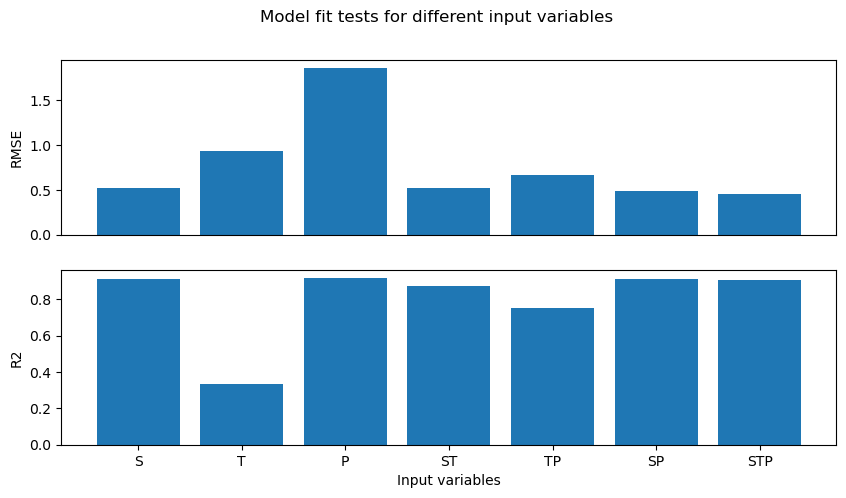

In [19]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
yname = ["RMSE", "R2"]

fig.suptitle("Model fit tests for different input variables")

for i, ax in enumerate(axs):
    ax.bar(list(model_dic.keys()), [mt[i + 1] for mt in model_test_dic.values()])
    ax.set_ylabel(yname[i])
    ax.set_xlabel("Input variables")
    if i<len(axs)-1:
        ax.set_xticks([])
        ax.set_xlabel("")
        

In [32]:
print(f"RMSE: all variables {model_test_dic["STP"][1]} v salinity only {model_test_dic["S"][1]}")
print(f"R2: all variables {model_test_dic["STP"][2]} v salinity only {model_test_dic["S"][2]}")

RMSE: all variables 0.2867172125600591 v salinity only 0.40845268001495616
R2: all variables 0.9428939567550774 v salinity only 0.9136560096726684


It is clear that salinity is the most important variable in the model. If we don't use it, the error blows up significantly. Indeed, we see that while it is better to include all the variables, salinity does a reasonable job on its own. 

Note that pressure/depth levels seem more important than temperature, but that may be due to there being less data available after QCing the pressure.

### 2.3. Apply model to AOR

Now that we have trained our model, we can apply it the Arctic Ocean Reanalysis. This contains temperature and salinity: now we can add our oxygen isotope tracer! The result is monthly, 0.125 deg data

In [13]:
# Convert to Cartesian coordinates
aor_cart = ml_model.spherical_to_cartesian(aor, "longitude", "latitude")

aor_oxy_vals = []
for t in aor.time.values:
    aor_oxy_vals.append(ml_model.apply_model(aor_cart.sel(time=t).drop_vars("time"), ["so", "thetao"], trained_model[0], trained_model[1], x="x", y="y", z="depth").values)


In [14]:
# Create dataarray
aor_oxy = xr.DataArray(
    data=np.array(aor_oxy_vals),
    dims= aor.dims,
    coords=aor.coords,
    name="oxygen_isotope_tracer"
)

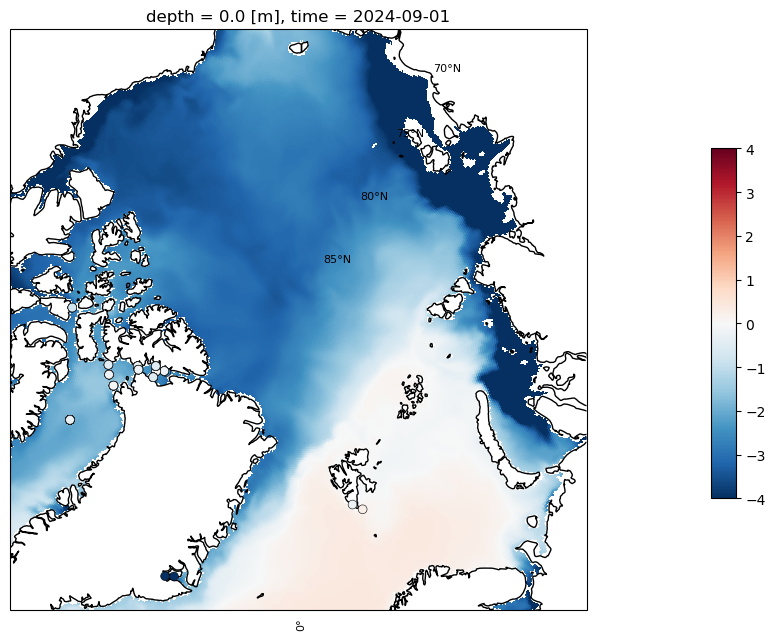

In [15]:
# Call class
arcticplot = ArcticPlotter(df_qcd[latitude_field], df_qcd[longitude_field])

# Select a month to compare the data with the model (same as in Sec. 1.2.3)
mo, yr = 9, 2024
df_1month = df_qcd[(df_qcd["datetime"].dt.year == yr) & (df_qcd["datetime"].dt.month == mo)]

# Plot the model output
fig, ax, p = multiplot(aor_oxy.sel(time=f"{yr}-{mo:02d}-01"), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

arcticplot.lon, arcticplot.lat = df_1month[longitude_field], df_1month[latitude_field]
sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[oxygen_iso_field], vmin=-4, vmax=4, cmap="RdBu_r")


In [26]:
## Compare the AOR temp & salinity with BAS Prealpha observations
rmse_oxy = compare_model_obs(df_qcd, aor_oxy, oxygen_iso_field, [], "datetime", longitude_field, latitude_field)
print(f"RMSE for d18O: {rmse_oxy:.3f} per mille")

RMSE for d18O: 1.676 per mille


In [22]:
aor_oxy.to_netcdf(CONFIG["arctic_reanalysis_oxy"])

#### 2.3.1. Create graphic of oxygen tracer over time

In [38]:
# Save frames for use in the gif
gif_indx=0
for i, t in enumerate(aor_oxy.time.values[:50]):
    tstr = aor_oxy.time.dt.strftime("%Y-%m-%d").values[i]
    # Save set of images
    fig, ax, p = multiplot(aor_oxy.sel(time=t), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", 
                           xyreg=(False,(70,90)))


    fig.savefig(f'./gif_plots/frame_{gif_indx:03d}.png', dpi=180, bbox_inches='tight')
    
    gif_indx+=1
    plt.close()

In [39]:
# Function for creating a gif from the frames
def gif_maker(gif_name, png_dir):    
        """Create a gif from a set of .png files in a directory.
        
        Parameters
        ----------
        gif_name : str
            Name of the output gif file.
        png_dir : str
            Directory containing the .png files.
        """
        # sort the .png files based on index used above
        images, image_file_names = [], []
        for file_name in os.listdir(png_dir):
            if file_name.endswith(".png"):
                image_file_names.append(file_name)
        sorted_files = sorted(image_file_names)

        # define some GIF parameters

        frame_length = 0.1  # seconds between frames
        end_pause = 0.1  # seconds to stay on last frame
        # loop through files, join them to image array, and write to GIF called 'wind_turbine_dist.gif'
        for ii in range(0, len(sorted_files)):
            file_path = os.path.join(png_dir, sorted_files[ii])
            if ii == len(sorted_files) - 1:
                for jj in range(0, int(end_pause / frame_length)):
                    images.append(imageio.imread(file_path))
            else:
                images.append(imageio.imread(file_path))
        # the duration is the time spent on each image (1/duration is frame rate)
        imageio.mimsave(gif_name, images, "GIF", duration=frame_length)

# Save the gif
gif_maker("aor_oxy_gif.gif", "gif_plots")

/tmp/ipykernel_2800551/1703153973.py:30: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

/tmp/ipykernel_2800551/1703153973.py:28: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



## 3. Modelling the detrended data

We compute the model based on anomalies rather than actuals

### 3.1. Compute climatologies and anomalies

We will base the anomalies off an AOR climatology. So, we generate an AOR climatology, then compute the in-situ anomalies from it.

In [40]:
# Create an AOR climatology
sal_aor_clim_da = climatology(sal_aor, tstep='month')
sal_aor_clim = sal_aor_clim_da.to_dataframe(name="so").dropna().reset_index()

temp_aor_clim_da = climatology(temp_aor, tstep='month')
temp_aor_clim = temp_aor_clim_da.to_dataframe(name="thetao").dropna().reset_index()

aor_clim = pd.merge(sal_aor_clim, temp_aor_clim, on=["month", "latitude", "longitude"])

In [ ]:
# Map the in-situ data to the AOR grid
grid = grid_from_resolution(0.125, bounds=[[-179.875, 180], [-89.875, 90]], coord_names=["longitude", "latitude"])

# Add grid coordinates 
df_gridd = map_to_grid(pl.from_pandas(df_qcd[["datetime", latitude_field, longitude_field, 
                                   salinity_field, temperature_field, oxygen_iso_field]]), 
                                   grid, obs_coords=[longitude_field, latitude_field], 
                                   grid_coords=["longitude", "latitude"]).to_pandas()

# Add a month column
df_gridd['month'] = df_gridd['datetime'].dt.month
df_gridd.rename(columns={"grid_Longitude": "longitude", "grid_Latitude": "latitude"}, inplace=True)

# Create anomaly by merging actual to climatology
df_anom = (
    df_gridd
    .merge(
        aor_clim,
        on=["month", "longitude", "latitude"],
        how="left",
    )
)

df_anom["temperature anomaly (oC)"] = df_anom[temperature_field] - df_anom["thetao"]
df_anom["salinity anomaly (pss)"] = df_anom[salinity_field] - df_anom["so"]

df_anom = df_anom[["datetime", 
                   longitude_field, 
                   latitude_field, 
                   temperature_field, 
                   salinity_field, 
                   oxygen_iso_field,
                   "temperature anomaly (oC)", 
                   "salinity anomaly (pss)"]
                   ].dropna()

df_anom["x"] = R * np.cos(np.deg2rad(df_anom[latitude_field])) * np.cos(np.deg2rad(df_anom[longitude_field]))
df_anom["y"] = R * np.cos(np.deg2rad(df_anom[latitude_field])) * np.sin(np.deg2rad(df_anom[longitude_field]))

### 3.2. Train the model after detrending

We can use the AOR model to detrend the data, meaning we won't have interannual variability baked in. Note that there will be interannual variability in the oxygen tracer (as we don't have model data for that) on which the model is trained.

In [ ]:
## Finally, train the model on the anomalies
df_anom_10 = df_anom.sample(frac=0.10) 
df_anom_90 = df_anom.drop(df_anom_10.index)

# Call the ML model
ml_model_anom = MLModel(df_anom_90, df_anom_10, [salinity_field, temperature_field], oxygen_iso_field, x="x", y="y", z="depth")
# Training
trained_model_anom = ml_model_anom.training()
# Inference
model_test_anom = ml_model_anom.inference(trained_model_anom[1], trained_model_anom[0])

ML Predicted Oxygen RMSE: 0.29463405932211395
ML Predicted Oxygen R2: 0.9370666479364298
ML Predicted Oxygen Error Percentiles [0.00597429 0.03428702 0.08342861 0.19206739 0.5195192 ]


So this doesn't improve the model; indeed it makes it slightly worse, but not by much. However, it does detrend it which means that we are accounting for interannual variability in the data. 

Note that we remove another 10000 data points by subtracting the climatology. I suspect that these are on-land points (as the AOR doesn't have these), so this is useful QC!

### 3.3. Apply model to detrended data

In [ ]:
aor_oxy_anom_vals = []
for t in aor.time.values:
    aor_oxy_anom_vals.append(ml_model.apply_model(aor.sel(time=t).drop("time"), ["so", "thetao"], trained_model_anom[0], trained_model_anom[1]).values)

/tmp/ipykernel_2800551/243588610.py:3: DeprecationWarning:

dropping variables using `drop` is deprecated; use drop_vars.



ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 924480 and the array at index 2 has size 2880

In [ ]:
aor_oxy_anom = xr.DataArray(
    data=np.array(aor_oxy_anom_vals),
    dims= aor.dims,
    coords=aor.coords, # {"time": 1, "longitude": aor.longitude, "latitude": aor.latitude},
    name="oxygen_isotope_tracer"
)

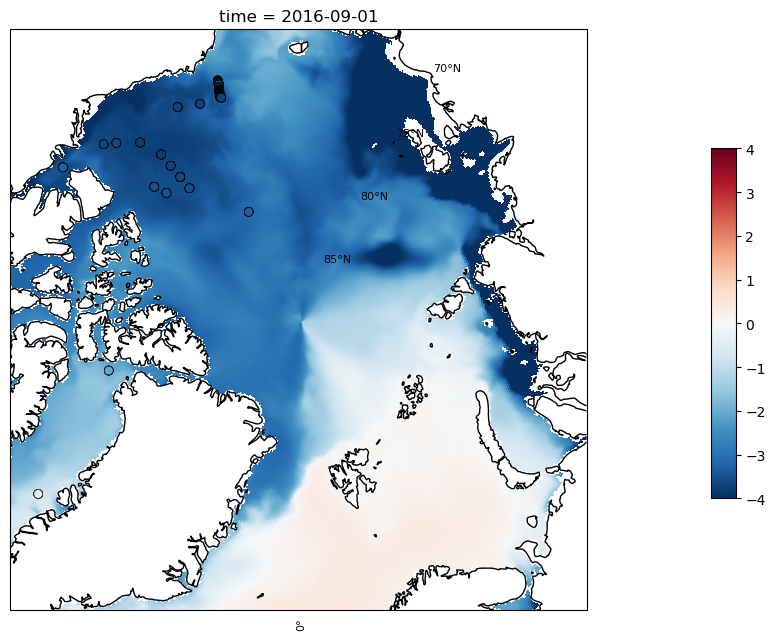

In [ ]:
# Plot the model output
fig, ax, p = multiplot(aor_oxy_anom.sel(time=f"{yr}-{mo:02d}-01"), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

arcticplot.lon, arcticplot.lat = df_1month[longitude_field], df_1month[latitude_field]
sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[oxygen_iso_field], vmin=-4, vmax=4, cmap="RdBu_r")

## 4. Modelling subsets of the data

### 4.1. Subset the data

There are a few options to do this:
* A whole year
* A whole month/season
* A specific region

In [85]:
df_qcd_sub = df_qc_dic["STP"]
yr = 2024

# Drop a specific year
df_dropyr = df_qcd_sub[~df_qcd_sub['datetime'].dt.year.isin([yr])]
df_1yr = df_qcd_sub[df_qcd_sub['datetime'].dt.year.isin([yr])]

# Drop a specific region
lon_reg, lat_reg = ((120, 150),(75, 80))

df_dropreg = df_qcd_sub[~((df_qcd_sub[longitude_field] >= lon_reg[0]) & (df_qcd_sub[longitude_field] <= lon_reg[1])
                          & (df_qcd_sub[latitude_field] >= lat_reg[0]) & (df_qcd_sub[latitude_field] <= lat_reg[1])
                          )]
df_reg = df_qcd_sub[((df_qcd_sub[longitude_field] >= lon_reg[0]) & (df_qcd_sub[longitude_field] <= lon_reg[1])
                          & (df_qcd_sub[latitude_field] >= lat_reg[0]) & (df_qcd_sub[latitude_field] <= lat_reg[1])
                          )]

### 4.2. Drop a year

In [86]:
# Select a subset
df_subset = df_dropyr
df_remain = df_1yr

#### 4.2.1. Train the model

In [87]:
# Create the 90% for training & 10% for inference
df_10_subset = df_subset.sample(frac=0.10)  # 10% sample
df_90_subset = df_subset.drop(df_10_subset.index)  # get rest

In [88]:
# Change input to exclude summer months
ml_model.df_10 = df_10_subset
ml_model.df_90 = df_90_subset

# Training
trained_model_subset = ml_model.training()
# Inference
model_test_subset = ml_model.inference(trained_model_subset[1], trained_model_subset[0],)

ML Predicted Oxygen RMSE: 0.3920658550304574
ML Predicted Oxygen R2: 0.9247642328207607
ML Predicted Oxygen Error Percentiles [0.00840229 0.04559561 0.11905828 0.28618202 0.92852571]


In [89]:
print("Different fits to models")
print(f"RMSE: full {model_test[1]} v subset {model_test_subset[1]}")
print(f"R2: full {model_test[2]} v subset {model_test_subset[2]}")
print(f"Error Percentiles: full {np.percentile(model_test[3], [5, 25, 50, 75, 95])} v subset {np.percentile(model_test_subset[3], [5, 25, 50, 75, 95])}")

Different fits to models
RMSE: full 0.40008731913441375 v subset 0.3920658550304574
R2: full 0.9326908628301388 v subset 0.9247642328207607
Error Percentiles: full [0.00863235 0.04938518 0.12140648 0.30321055 0.92856065] v subset [0.00840229 0.04559561 0.11905828 0.28618202 0.92852571]


#### 4.2.2. Apply model to AOR

In [90]:
# Convert to Cartesian coordinates
aor_oxy_1yr = timeseg(aor_oxy, "time", (f"{yr}-01-01", f"{yr}-12-01"))

aor_sub_cart = ml_model.spherical_to_cartesian(aor,"longitude", "latitude")

aor_sub_oxy_vals = []
for t in aor_oxy_1yr.time.values:
    aor_sub_oxy_vals.append(ml_model.apply_model(aor_sub_cart.sel(time=t).drop_vars("time"),["so", "thetao"], trained_model_subset[0], trained_model_subset[1], x="x", y="y").values)


In [91]:
# Create dataarray
aor_oxy_subset = xr.DataArray(
    data=np.array(aor_sub_oxy_vals),
    dims= aor_oxy_1yr.dims,
    coords=aor_oxy_1yr.coords,
    name="oxygen_isotope_tracer"
)

##### Plots

In [92]:
# Call class
arcticplot = ArcticPlotter(df_qcd_sub[latitude_field], df_qcd_sub[longitude_field])

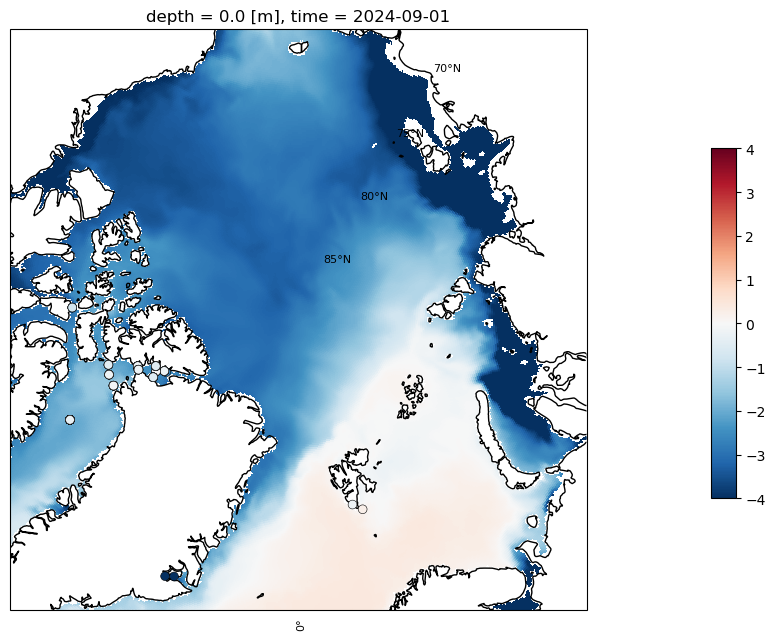

In [93]:
# Select a month to compare the data with the model (same as in Sec. 1.2.3)
mo, yr = 9, 2024
df_1month_subset = df_remain[(df_remain["datetime"].dt.year == yr) & (df_remain["datetime"].dt.month == mo)]

# Plot the model output
fig, ax, p = multiplot(aor_oxy_subset.sel(time=f"{yr}-{mo:02d}-01"), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

arcticplot.lon, arcticplot.lat = df_1month_subset[longitude_field], df_1month_subset[latitude_field]
sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month_subset[oxygen_iso_field], vmin=-4, vmax=4, cmap="RdBu_r")

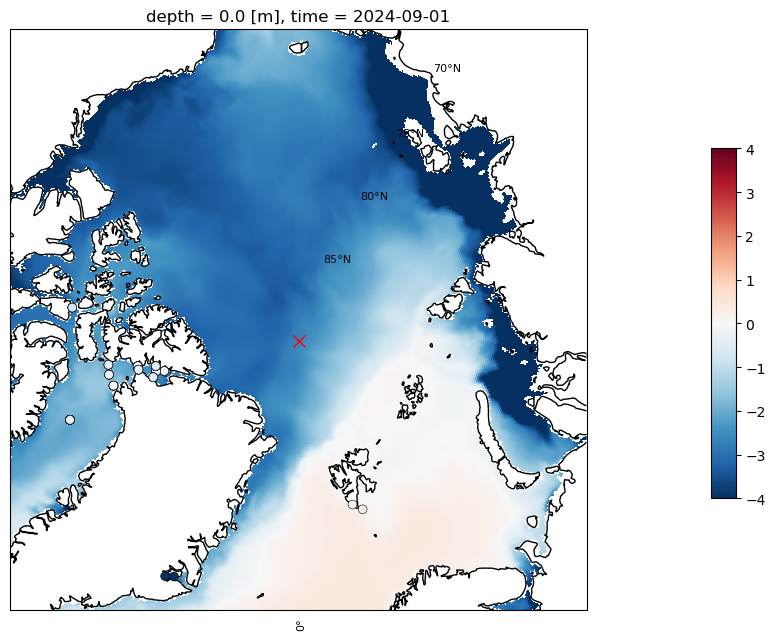

In [94]:
# Select a month to compare the data with the model (same as in Sec. 1.2.3)
mo, yr = 9, 2024
df_1month = df_qcd[(df_qcd["datetime"].dt.year == yr) & (df_qcd["datetime"].dt.month == mo)]

# Plot the model output
fig, ax, p = multiplot(aor_oxy.sel(time=f"{yr}-{mo:02d}-01"), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

arcticplot.lon, arcticplot.lat = df_1month[longitude_field], df_1month[latitude_field]
sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[oxygen_iso_field], vmin=-4, vmax=4, cmap="RdBu_r")

ax.plot(-7.375, 88.625, 'rx', markersize=8, transform=ccrs.PlateCarree())

ValueError: not enough values to unpack (expected at least 1, got 0)

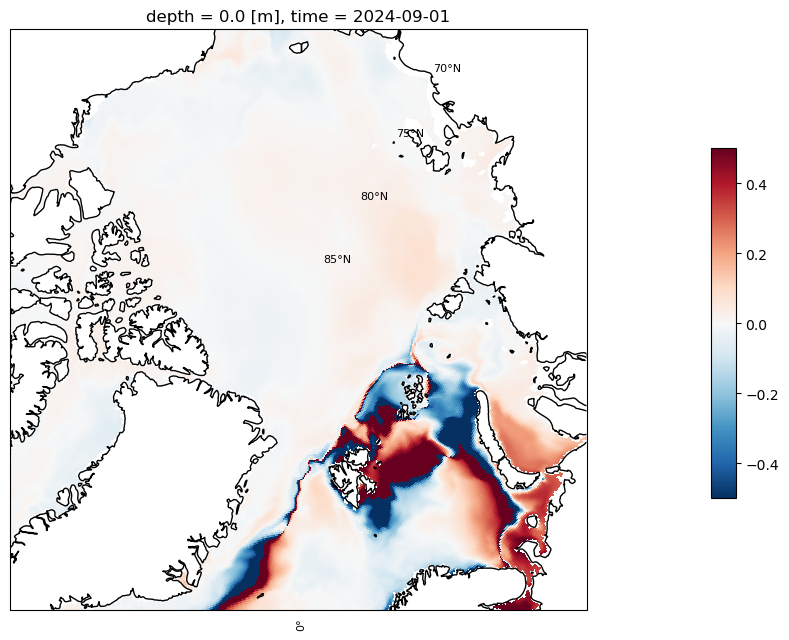

In [95]:
# Compare the two directly by plotting the fractional difference
fig, ax, p = multiplot(2*(aor_oxy_subset.sel(time=f"{yr}-{mo:02d}-01")-aor_oxy.sel(time=f"{yr}-{mo:02d}-01"))/(aor_oxy_subset.sel(time=f"{yr}-{mo:02d}-01")+aor_oxy.sel(time=f"{yr}-{mo:02d}-01")), vmin=-0.5, vmax=0.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))


##### Comparison with BAS data

In [96]:
rmse_oxy_2024 = compare_model_obs(df_1yr, aor_oxy_1yr, oxygen_iso_field, [], "datetime", longitude_field, latitude_field)
rmse_oxy_sub_2024 = compare_model_obs(df_1yr, aor_oxy_subset, oxygen_iso_field, [], "datetime", longitude_field, latitude_field)

print(f"RMSE for d18O full model in 2024: {rmse_oxy_2024:.3f} per mille")
print(f"RMSE for d18O subset model in 2024: {rmse_oxy_sub_2024:.3f} per mille")

RMSE for d18O full model in 2024: 1.039 per mille
RMSE for d18O subset model in 2024: 1.069 per mille


### 4.3. Drop a region

In [97]:
# Select a subset
df_subset = df_dropreg
df_remain = df_reg

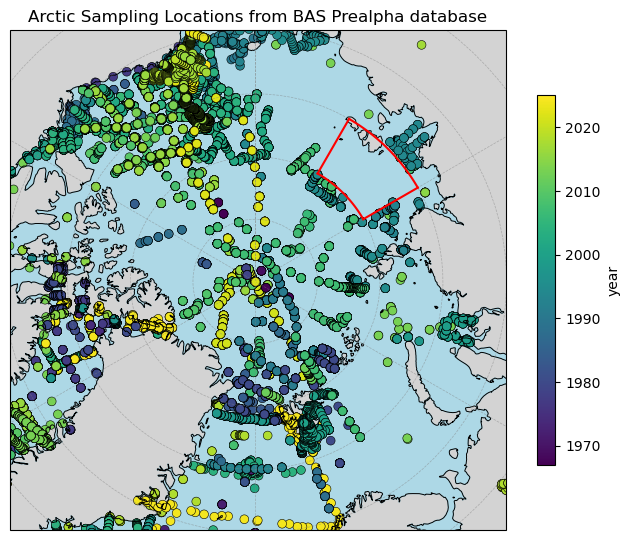

In [98]:
# Call class
arcticplot = ArcticPlotter(df_subset[latitude_field], df_subset[longitude_field])

# Plot by year
arcticplot.title = "Arctic Sampling Locations from BAS Prealpha database"
fig, ax = arcticplot.plot(cbar_data=df_subset["datetime"].dt.year)
add_region_highlight(axs=ax, reg=(*lon_reg, *lat_reg), color='red')

#### 4.3.1. Train the model

In [99]:
# Create the 90% for training & 10% for inference
df_10_subset = df_subset.sample(frac=0.10)  # 10% sample
df_90_subset = df_subset.drop(df_10_subset.index)  # get rest

In [100]:
# Change input to exclude summer months
ml_model.df_10 = df_10_subset
ml_model.df_90 = df_90_subset

# Training
trained_model_subset = ml_model.training()
# Inference
model_test_subset = ml_model.inference(trained_model_subset[1], trained_model_subset[0],)

ML Predicted Oxygen RMSE: 0.517282977842451
ML Predicted Oxygen R2: 0.8667585808719913
ML Predicted Oxygen Error Percentiles [0.00892818 0.04988009 0.12564151 0.30566435 0.92555684]


In [101]:
print("Different fits to models")
print(f"RMSE: full {model_test[1]} v subset {model_test_subset[1]}")
print(f"R2: full {model_test[2]} v subset {model_test_subset[2]}")
print(f"Error Percentiles: full {np.percentile(model_test[3], [5, 25, 50, 75, 95])} v subset {np.percentile(model_test_subset[3], [5, 25, 50, 75, 95])}")

Different fits to models
RMSE: full 0.40008731913441375 v subset 0.517282977842451
R2: full 0.9326908628301388 v subset 0.8667585808719913
Error Percentiles: full [0.00863235 0.04938518 0.12140648 0.30321055 0.92856065] v subset [0.00892818 0.04988009 0.12564151 0.30566435 0.92555684]


#### 4.2.2. Apply model to AOR

In [102]:
# Convert to Cartesian coordinates
aor_sub_cart = ml_model.spherical_to_cartesian(aor,"longitude", "latitude")

aor_sub_oxy_vals = []
for t in aor_sub_cart.time.values:
    aor_sub_oxy_vals.append(ml_model.apply_model(aor_sub_cart.sel(time=t).drop_vars("time"),["so", "thetao"], trained_model_subset[0], trained_model_subset[1], x="x", y="y").values)


In [103]:
# Create dataarray
aor_oxy_subset = xr.DataArray(
    data=np.array(aor_sub_oxy_vals),
    dims= aor_oxy.dims,
    coords=aor_oxy.coords,
    name="oxygen_isotope_tracer"
)

##### Plots

In [104]:
# Call class
arcticplot = ArcticPlotter(df_qcd_sub[latitude_field], df_qcd_sub[longitude_field])

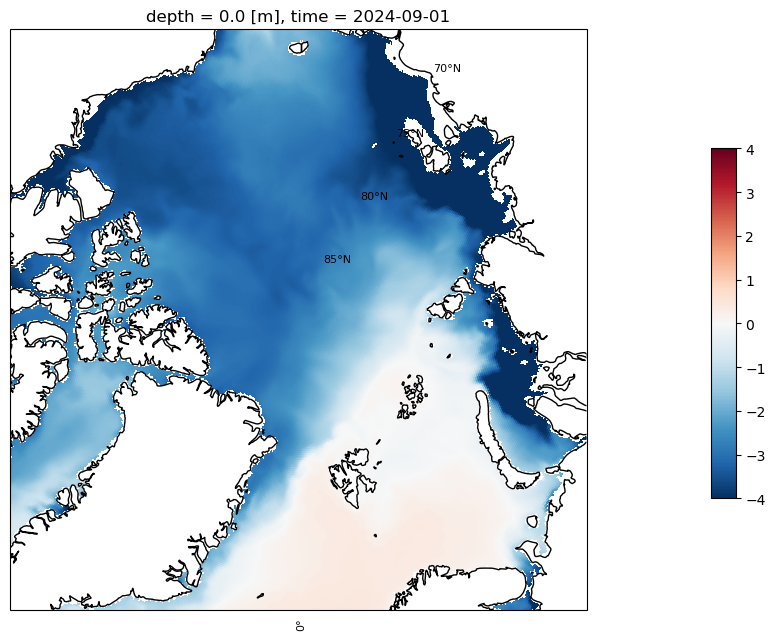

In [105]:
# Select a month to compare the data with the model (same as in Sec. 1.2.3)
mo, yr = 9, 2024
df_1month_subset = df_remain[(df_remain["datetime"].dt.year == yr) & (df_remain["datetime"].dt.month == mo)]

# Plot the model output
fig, ax, p = multiplot(aor_oxy_subset.sel(time=f"{yr}-{mo:02d}-01"), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

arcticplot.lon, arcticplot.lat = df_1month_subset[longitude_field], df_1month_subset[latitude_field]
sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month_subset[oxygen_iso_field], vmin=-4, vmax=4, cmap="RdBu_r")

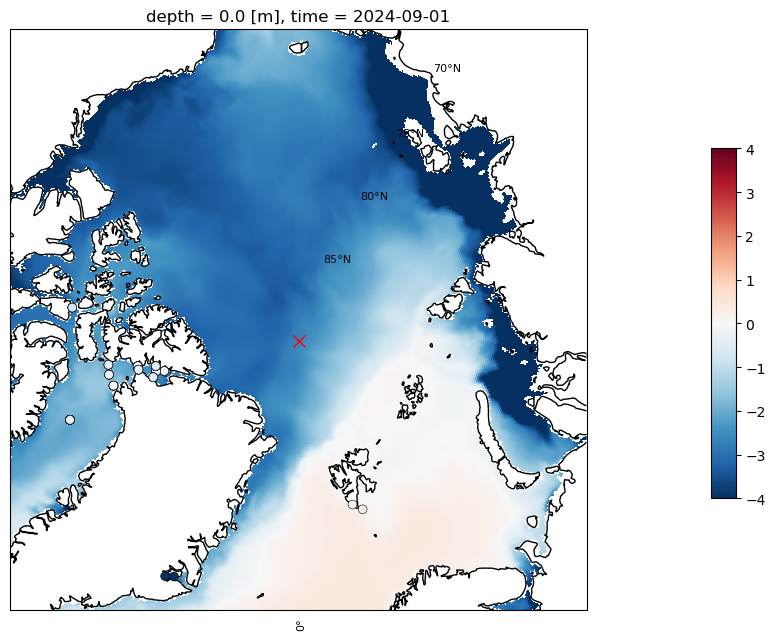

In [106]:
# Select a month to compare the data with the model (same as in Sec. 1.2.3)
mo, yr = 9, 2024
df_1month = df_qcd[(df_qcd["datetime"].dt.year == yr) & (df_qcd["datetime"].dt.month == mo)]

# Plot the model output
fig, ax, p = multiplot(aor_oxy.sel(time=f"{yr}-{mo:02d}-01"), vmin=-4, vmax=4, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))

arcticplot.lon, arcticplot.lat = df_1month[longitude_field], df_1month[latitude_field]
sc = arcticplot.scatter_plot(ax=ax, cbar_data=df_1month[oxygen_iso_field], vmin=-4, vmax=4, cmap="RdBu_r")

ax.plot(-7.375, 88.625, 'rx', markersize=8, transform=ccrs.PlateCarree())

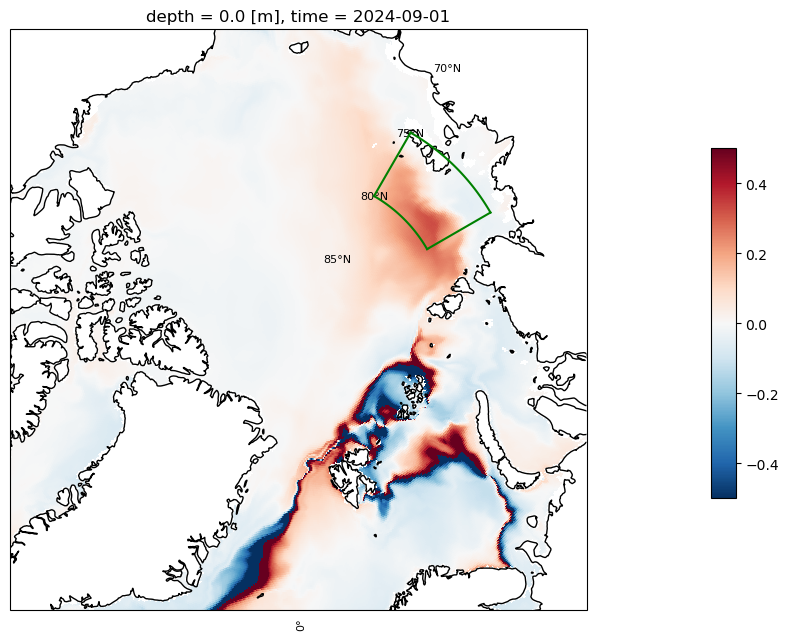

In [110]:
# Compare the two directly by plotting the fractional difference
fig, ax, p = multiplot(2*(aor_oxy_subset.sel(time=f"{yr}-{mo:02d}-01")-aor_oxy.sel(time=f"{yr}-{mo:02d}-01"))/(aor_oxy_subset.sel(time=f"{yr}-{mo:02d}-01")+aor_oxy.sel(time=f"{yr}-{mo:02d}-01")), vmin=-0.5, vmax=0.5, cmap="RdBu_r", map_type="NorthPolarStereo", xyreg=(False,(70,90)))
add_region_highlight(axs=ax, reg=(*lon_reg, *lat_reg), color='green')


##### Comparison with BAS data

In [108]:
aor_oxy_reg = xy_region(aor_oxy, "longitude", "latitude", lon_reg, lat_reg,)
aor_oxy_subset_reg = xy_region(aor_oxy_subset, "longitude", "latitude", lon_reg, lat_reg)

rmse_oxy_reg = compare_model_obs(df_reg, aor_oxy_reg, oxygen_iso_field, [], "datetime", longitude_field, latitude_field)
rmse_oxy_sub_reg = compare_model_obs(df_reg, aor_oxy_subset_reg, oxygen_iso_field, [], "datetime", longitude_field, latitude_field)

print(f"RMSE for d18O full model in 2024: {rmse_oxy_reg:.3f} per mille")
print(f"RMSE for d18O subset model in 2024: {rmse_oxy_sub_reg:.3f} per mille")

RMSE for d18O full model in 2024: 2.474 per mille
RMSE for d18O subset model in 2024: 3.242 per mille
